## Imports and Function Definitions

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, average_precision_score
import torch
from torch.nn.functional import softmax

In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Define transforms with new resolution
train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset
train_dataset = GTSRB(root="./data", split='train', transform=train_transform, download=True)
test_dataset = GTSRB(root="./data", split='test', transform=test_transform, download=True)

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    return running_loss / len(train_loader), train_accuracy


# Testing function
def test(model, device, test_loader):
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy




def evaluate_model(model, test_loader, device, num_classes=43):
    model.eval()  # Set model to evaluation mode
    all_probs = []
    all_labels = []

    # Evaluate the model and collect probabilities and true labels
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            probabilities = softmax(outputs, dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all batch results
    predicted_probs = np.concatenate(all_probs, axis=0)
    true_labels = np.concatenate(all_labels, axis=0)
    predicted_labels = np.argmax(predicted_probs, axis=1)

    # Confusion Matrix
    cf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Classification Report
    class_report = classification_report(true_labels, predicted_labels)
    print("Classification Report:")
    print(class_report)

    # ROC-AUC
    roc_auc = roc_auc_score((true_labels[:, None] == np.arange(num_classes)).astype(int), predicted_probs, average='macro')
    print(f"AUC-ROC: {roc_auc}")

    # ROC Curve
    fpr, tpr, _ = roc_curve((true_labels[:, None] == np.arange(num_classes)).astype(int).ravel(), predicted_probs.ravel())
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Mean Average Precision (mAP)
    true_labels_binary = (true_labels[:, None] == np.arange(num_classes)).astype(int)
    average_precisions = [average_precision_score(true_labels_binary[:, i], predicted_probs[:, i]) for i in range(num_classes)]
    mean_ap = np.mean(average_precisions)
    print(f"Mean Average Precision (mAP): {mean_ap}")


100%|██████████| 187490228/187490228 [00:08<00:00, 22321959.78it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 88978620/88978620 [00:04<00:00, 19150918.07it/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99620/99620 [00:00<00:00, 281835.65it/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **LeNet-5**


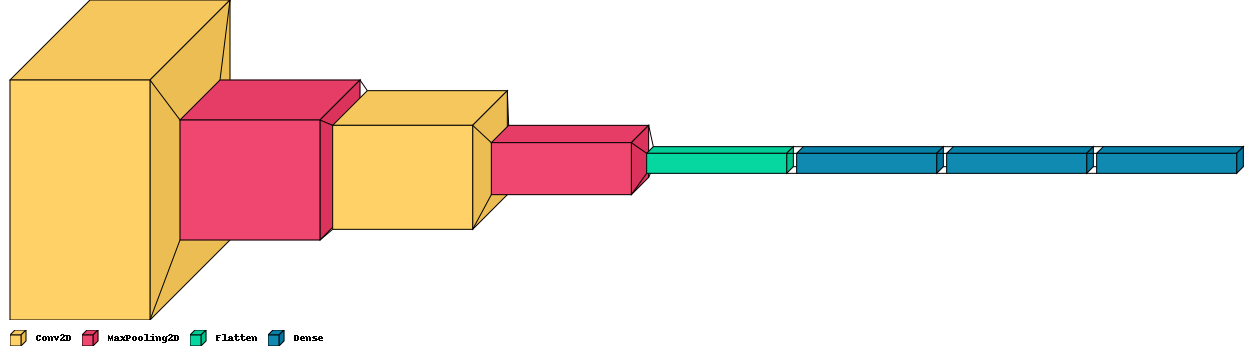

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the LeNet model in TensorFlow Keras
def create_lenet_model():
    model = models.Sequential()
    model.add(layers.Conv2D(6, (5, 5), activation='relu', input_shape=(64, 64, 3)))  # Adjust input shape as needed
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(43, activation='softmax'))  # Output layer for 43 classes
    return model

modelLeNet5 = create_lenet_model()

# Import visualization tools
import visualkeras
from PIL import Image
from IPython.display import display

# Create visualization of the model
image = visualkeras.layered_view(modelLeNet5, legend=True, scale_xy=4, scale_z=120, max_z=140)  # Create a PIL image

# Display the image in a Colab notebook
display(image)


In [ ]:
# Define LeNet model adapted for 64x64 input images
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Recalculate the size of the flattened vector
        # After two rounds of Conv2d and MaxPool2d, the image size changes as follows:
        # 64 -> 60 (Conv2d) -> 30 (MaxPool) -> 26 (Conv2d) -> 13 (MaxPool)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 13 * 13)  # Adjust the view to match new flattened size
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Main training and testing process
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_LeNet = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_LeNet.parameters(), lr=0.001)
epochs = 30

for epoch in range(epochs):
    train_loss, train_accuracy = train(model_LeNet, device, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}, Train Accuracy: {train_accuracy}%")

    test_accuracy = test(model_LeNet, device, test_loader)
    print(f"Test Accuracy: {test_accuracy}%")


Epoch 1/30, Loss: 2.0783441468394344, Train Accuracy: 38.6524024024024%
Test Accuracy: 51.4806017418844%
Epoch 2/30, Loss: 0.7132154016686286, Train Accuracy: 76.84309309309309%
Test Accuracy: 73.80047505938242%
Epoch 3/30, Loss: 0.37728032857465515, Train Accuracy: 88.34084084084084%
Test Accuracy: 78.63024544734759%
Epoch 4/30, Loss: 0.2577432307014934, Train Accuracy: 92.04954954954955%
Test Accuracy: 80.50673000791765%
Epoch 5/30, Loss: 0.2026001301815184, Train Accuracy: 93.64114114114115%
Test Accuracy: 82.86619160728425%
Epoch 6/30, Loss: 0.16122193207933033, Train Accuracy: 95.19144144144144%
Test Accuracy: 84.33095803642122%
Epoch 7/30, Loss: 0.14088121761860464, Train Accuracy: 95.71321321321321%
Test Accuracy: 84.52098178939033%
Epoch 8/30, Loss: 0.11818884975082583, Train Accuracy: 96.40765765765765%
Test Accuracy: 85.30482977038797%
Epoch 9/30, Loss: 0.11250166471252482, Train Accuracy: 96.6403903903904%
Test Accuracy: 85.70863024544735%
Epoch 10/30, Loss: 0.09834615718707

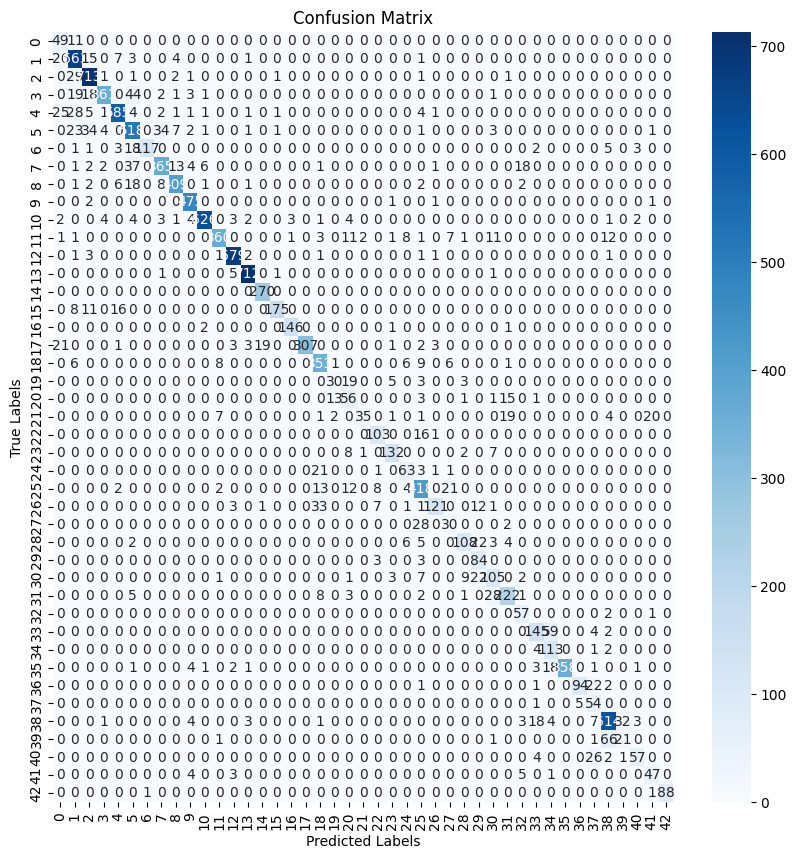

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.82      0.53        60
           1       0.84      0.92      0.88       720
           2       0.88      0.95      0.92       750
           3       0.97      0.80      0.88       450
           4       0.94      0.89      0.91       660
           5       0.79      0.82      0.81       630
           6       0.99      0.78      0.87       150
           7       0.88      0.81      0.84       450
           8       0.93      0.91      0.92       450
           9       0.95      0.99      0.97       480
          10       0.98      0.95      0.96       660
          11       0.95      0.86      0.90       420
          12       0.97      0.98      0.98       690
          13       0.98      0.99      0.98       720
          14       0.93      1.00      0.96       270
          15       0.98      0.83      0.90       210
          16       0.97      0.97      0.97       150
    

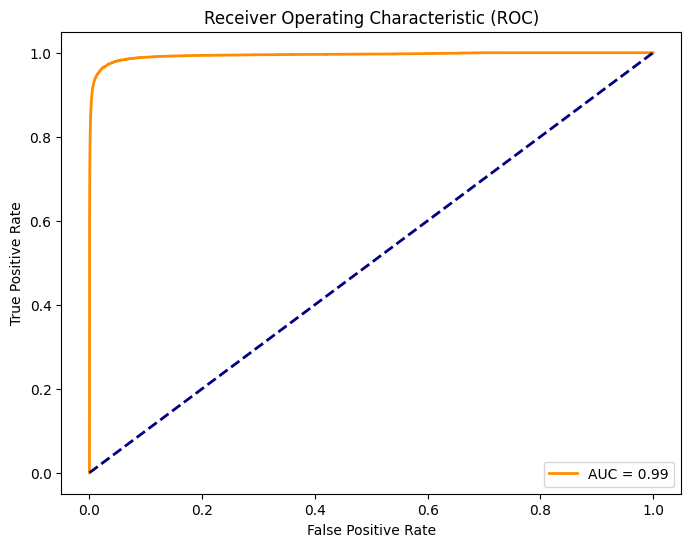

Mean Average Precision (mAP): 0.8655191752856952


In [ ]:
evaluate_model(model_LeNet, test_loader, device)

In [ ]:
from torchsummary import summary

# Print model summary (for parameters count)
model_LeNet = LeNet().to(device)
summary(model_LeNet, input_size=(3, 64, 64))  # Input shape as CxHxW


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 60, 60]             456
         MaxPool2d-2            [-1, 6, 30, 30]               0
            Conv2d-3           [-1, 16, 26, 26]           2,416
         MaxPool2d-4           [-1, 16, 13, 13]               0
            Linear-5                  [-1, 120]         324,600
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 43]           3,655
Total params: 341,291
Trainable params: 341,291
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.31
Params size (MB): 1.30
Estimated Total Size (MB): 1.66
----------------------------------------------------------------


In [ ]:
# FLOPs for each layer
flops_conv1 = (5 * 5 * 3) * 6 * 60 * 60  # kernel size * in_channels * out_channels * output height * output width
flops_pool1 = 0  # Pooling layers do not involve multiplicative operations, can be omitted in FLOP count
flops_conv2 = (5 * 5 * 6) * 16 * 26 * 26  # as above for second conv layer
flops_pool2 = 0  # as for first pooling layer

# Fully connected layers calculations are as follows:
# FC layer FLOPs = 2 * input_nodes * output_nodes
# The factor of 2 accounts for the multiplication and addition for each connection
flops_fc1 = 2 * (16 * 13 * 13) * 120  # from 16 channels of 13x13 each to 120 nodes
flops_fc2 = 2 * 120 * 84  # from 120 nodes to 84 nodes
flops_fc3 = 2 * 84 * 43   # from 84 nodes to 43 output nodes (class probabilities)

# Total FLOPs
total_flops = flops_conv1 + flops_conv2 + flops_fc1 + flops_fc2 + flops_fc3

print(f"Total FLOPs: {total_flops}")


Total FLOPs: 3918744


In [ ]:
torch.save(model_LeNet.state_dict(), 'lenet_model.pth')

# **AlexNet**

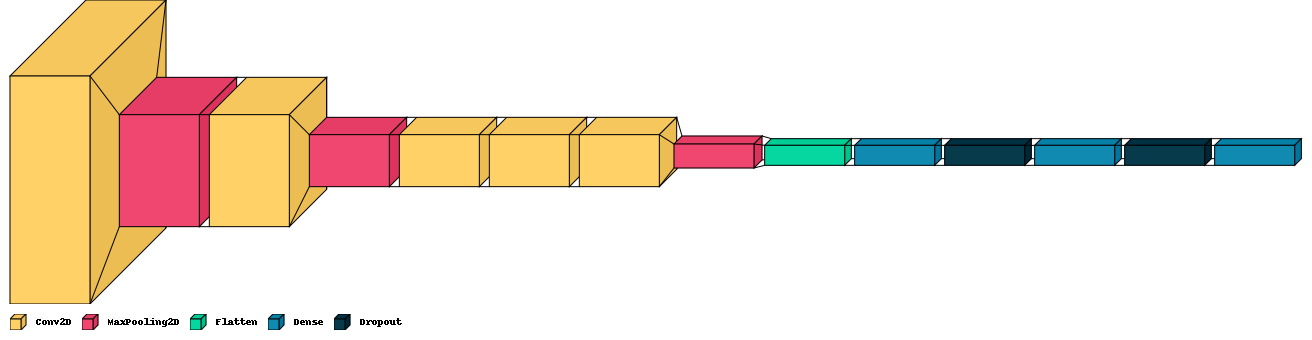

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import visualkeras
from PIL import Image
from IPython.display import display

# Define the AlexNet model in TensorFlow Keras
def create_alexnet_model(num_classes=43):
    model = models.Sequential()
    model.add(layers.Conv2D(64, kernel_size=11, strides=4, padding='same', activation='relu', input_shape=(227, 227, 3)))
    model.add(layers.MaxPooling2D(pool_size=3, strides=2))
    model.add(layers.Conv2D(192, kernel_size=5, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=3, strides=2))
    model.add(layers.Conv2D(384, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.Conv2D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=3, strides=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

model_alexnet = create_alexnet_model()

# Create visualization of the model
image = visualkeras.layered_view(model_alexnet, legend=True, scale_xy=4, scale_z=80, max_z=80)  # Create a PIL image

# Display the image in a Colab notebook
display(image)


In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=43):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_AlexNet = AlexNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_AlexNet.parameters(), lr=0.001)

# Training loop
epochs = 30
for epoch in range(epochs):
    train_loss, train_accuracy = train(model_AlexNet, device, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}, Train Accuracy: {train_accuracy}%")

    test_accuracy = test(model_AlexNet, device, test_loader)
    print(f"Test Accuracy: {test_accuracy}%")


Epoch 1/30, Loss: 2.862568388739936, Train Accuracy: 16.76051051051051%
Test Accuracy: 33.16706254948535%
Epoch 2/30, Loss: 1.7394210983523362, Train Accuracy: 41.33258258258258%
Test Accuracy: 42.913697545526524%
Epoch 3/30, Loss: 1.4062437931124827, Train Accuracy: 51.340090090090094%
Test Accuracy: 54.1409342834521%
Epoch 4/30, Loss: 1.156534657203894, Train Accuracy: 59.68468468468468%
Test Accuracy: 55.28899445764054%
Epoch 5/30, Loss: 0.9850139484988699, Train Accuracy: 66.04354354354355%
Test Accuracy: 59.794140934283455%
Epoch 6/30, Loss: 0.8621056904609826, Train Accuracy: 70.4391891891892%
Test Accuracy: 60.950118764845605%
Epoch 7/30, Loss: 0.7877957572182306, Train Accuracy: 73.76126126126127%
Test Accuracy: 65.91448931116389%
Epoch 8/30, Loss: 0.7284074403542123, Train Accuracy: 75.8108108108108%
Test Accuracy: 70.16627078384798%
Epoch 9/30, Loss: 0.6759503236491617, Train Accuracy: 77.72897897897897%
Test Accuracy: 69.96832937450515%
Epoch 10/30, Loss: 0.6367286069215916,

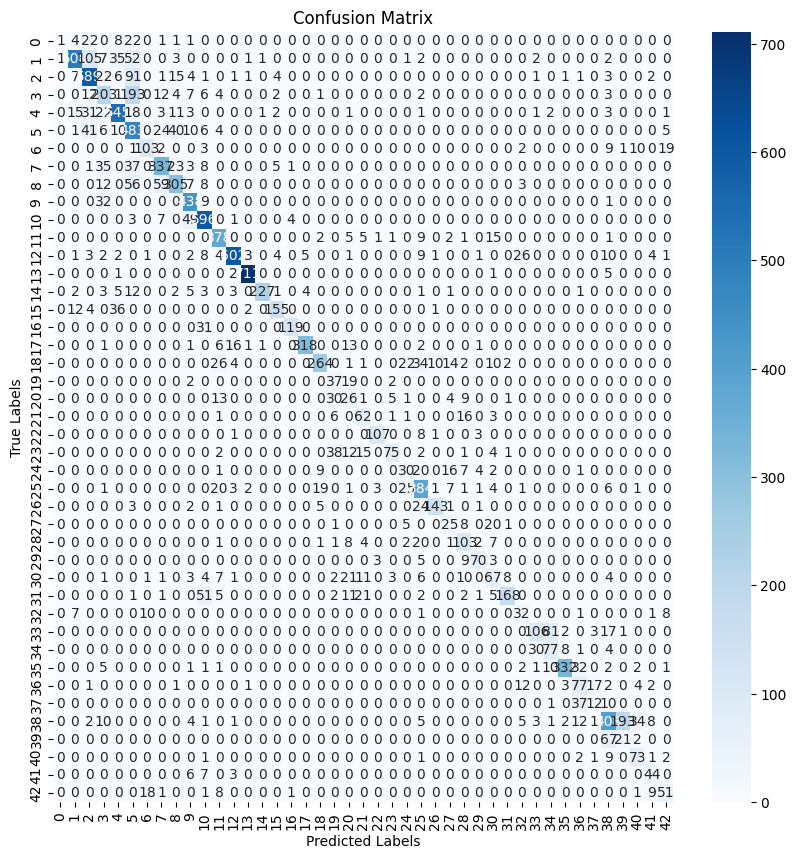

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.02      0.03        60
           1       0.91      0.71      0.80       720
           2       0.73      0.79      0.75       750
           3       0.56      0.45      0.50       450
           4       0.84      0.83      0.83       660
           5       0.50      0.77      0.60       630
           6       0.77      0.69      0.73       150
           7       0.75      0.75      0.75       450
           8       0.75      0.68      0.71       450
           9       0.80      0.91      0.85       480
          10       0.80      0.90      0.85       660
          11       0.78      0.90      0.84       420
          12       0.94      0.87      0.91       690
          13       0.98      0.99      0.99       720
          14       0.99      0.84      0.91       270
          15       0.90      0.74      0.81       210
          16       0.95      0.79      0.87       150
    

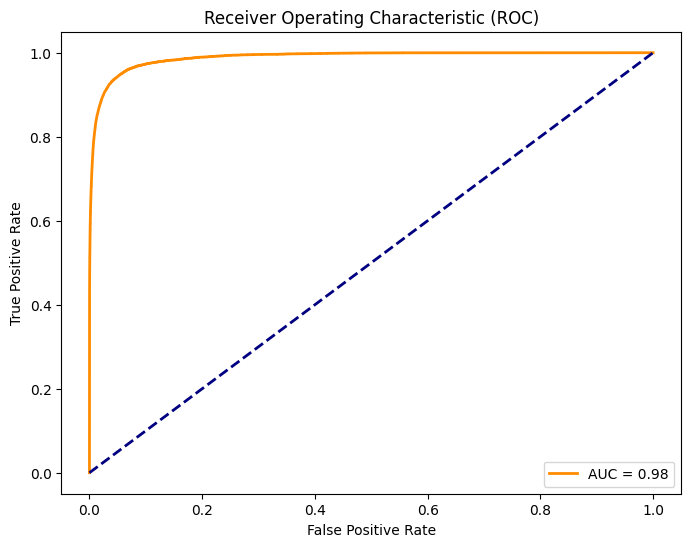

Mean Average Precision (mAP): 0.7146782752069285


In [ ]:
evaluate_model(model_AlexNet, test_loader, device)

In [ ]:
from torchsummary import summary
summary(model_AlexNet, input_size=(3, 64, 64))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 15, 15]          23,296
              ReLU-2           [-1, 64, 15, 15]               0
         MaxPool2d-3             [-1, 64, 7, 7]               0
            Conv2d-4            [-1, 192, 7, 7]         307,392
              ReLU-5            [-1, 192, 7, 7]               0
         MaxPool2d-6            [-1, 192, 3, 3]               0
            Conv2d-7            [-1, 384, 3, 3]         663,936
              ReLU-8            [-1, 384, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         884,992
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# Calculate FLOPs
flops = {
    "conv1": 11 * 11 * 3 * 64 * 55 * 55,
    "conv2": 5 * 5 * 64 * 192 * 27 * 27,
    "conv3": 3 * 3 * 192 * 384 * 13 * 13,
    "conv4": 3 * 3 * 384 * 256 * 13 * 13,
    "conv5": 3 * 3 * 256 * 256 * 13 * 13,
    "fc1": 2 * (256 * 6 * 6) * 4096,
    "fc2": 2 * 4096 * 4096,
    "fc3": 2 * 4096 * 43
}
total_flops_alexnet = sum(flops.values())
print(f"Total FLOPs: {total_flops_alexnet}")

torch.save(model_AlexNet.state_dict(), 'alexnet_model.pth')

Total FLOPs: 764970688


# **VGG 16**

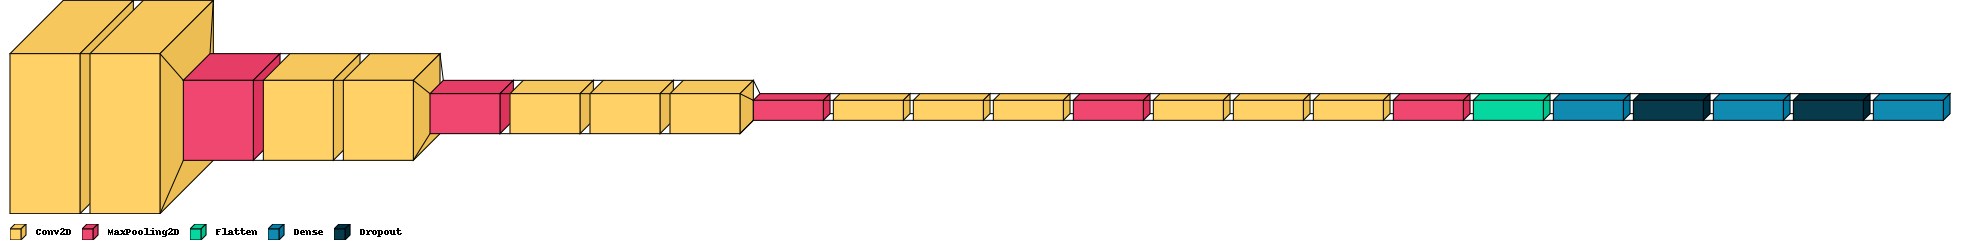

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import visualkeras
from PIL import Image
from IPython.display import display

# Define a custom VGG-like model in TensorFlow Keras
def create_custom_vgg_model():
    model = models.Sequential([
 layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Block 2
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Block 3
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Block 4
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Block 5
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Classification block
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(43, activation='softmax')
    ])
    return model

# Create the model
model_custom_vgg = create_custom_vgg_model()

# Create visualization of the model
image = visualkeras.layered_view(model_custom_vgg, legend=True, scale_xy=5, scale_z=70, max_z=70)

# Display the image in a notebook
display(image)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class VGG(nn.Module):
    def __init__(self, num_classes=43):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512 * 2 * 2)  # Flatten the output for the fully connected layer
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_VGG = VGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_VGG.parameters(), lr=0.001)
epochs = 30

for epoch in range(epochs):
    train_loss, train_accuracy = train(model_VGG, device, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}, Train Accuracy: {train_accuracy}%")

    test_accuracy = test(model_VGG, device, test_loader)
    print(f"Test Accuracy: {test_accuracy}%")


Epoch 1/30, Loss: 2.2890195070410804, Train Accuracy: 32.71771771771772%
Test Accuracy: 59.311163895486935%
Epoch 2/30, Loss: 0.8263647687806785, Train Accuracy: 71.59534534534535%
Test Accuracy: 79.92082343626286%
Epoch 3/30, Loss: 0.41242536305666544, Train Accuracy: 85.6981981981982%
Test Accuracy: 86.60332541567696%
Epoch 4/30, Loss: 0.24755284876274547, Train Accuracy: 91.62162162162163%
Test Accuracy: 89.27157561361837%
Epoch 5/30, Loss: 0.18856954281117846, Train Accuracy: 93.72747747747748%
Test Accuracy: 91.52810768012668%
Epoch 6/30, Loss: 0.14369335565582025, Train Accuracy: 95.31906906906907%
Test Accuracy: 92.93745051464767%
Epoch 7/30, Loss: 0.11617525167566695, Train Accuracy: 96.32132132132132%
Test Accuracy: 93.50752177355503%
Epoch 8/30, Loss: 0.10094451954771431, Train Accuracy: 96.6403903903904%
Test Accuracy: 92.92953285827394%
Epoch 9/30, Loss: 0.09284713671026791, Train Accuracy: 97.02702702702703%
Test Accuracy: 94.26761678543151%
Epoch 10/30, Loss: 0.0788454862

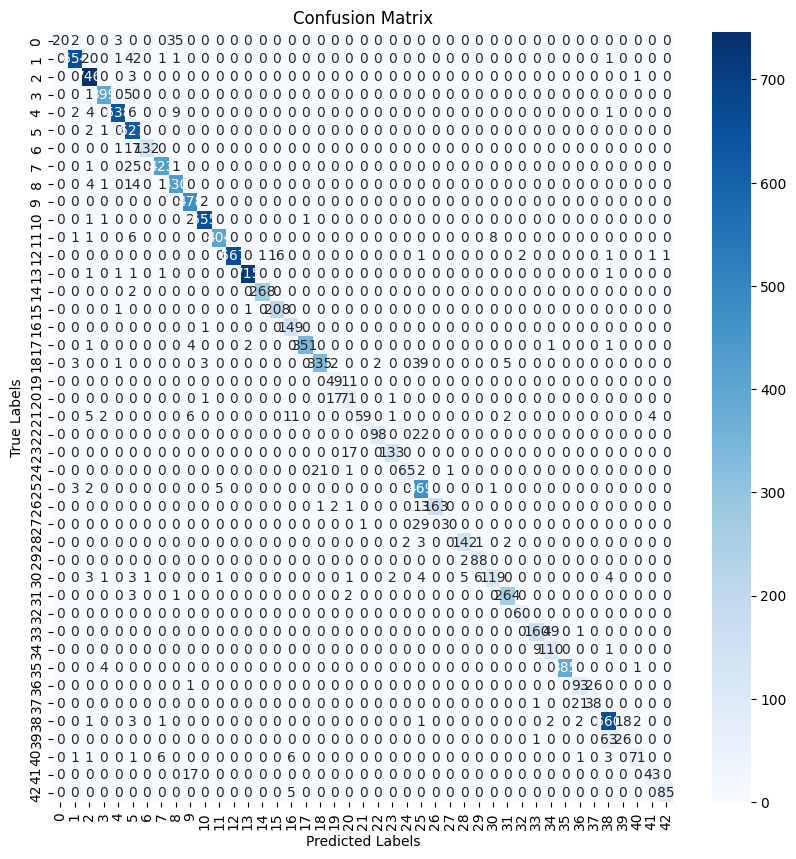

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        60
           1       0.98      0.91      0.94       720
           2       0.94      0.99      0.97       750
           3       0.98      0.89      0.93       450
           4       0.99      0.97      0.98       660
           5       0.78      1.00      0.88       630
           6       0.99      0.88      0.93       150
           7       0.98      0.94      0.96       450
           8       0.90      0.96      0.93       450
           9       0.94      1.00      0.97       480
          10       0.99      0.99      0.99       660
          11       0.99      0.96      0.97       420
          12       1.00      0.97      0.98       690
          13       1.00      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       0.93      0.99      0.96       210
          16       0.87      0.99      0.93       150
    

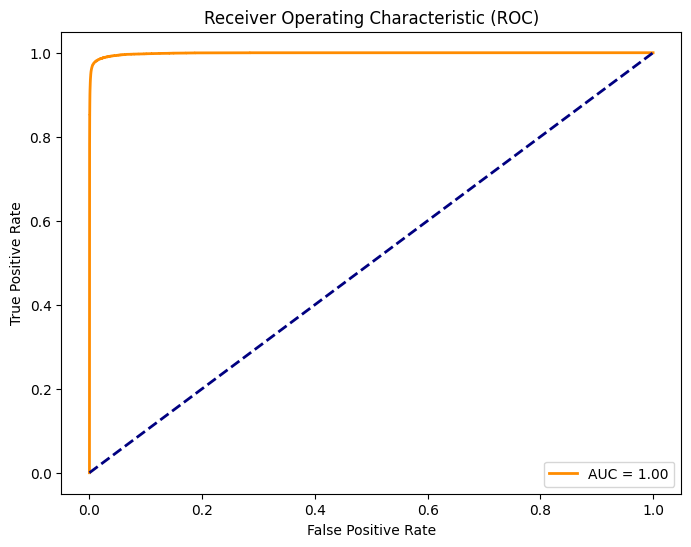

Mean Average Precision (mAP): 0.923498654450272


In [ ]:
evaluate_model(model_VGG, test_loader, device, num_classes=43)

In [ ]:
from torchsummary import summary

# Print model summary (for parameters count)
model_VGG = VGG().to(device)
summary(model_VGG, input_size=(3, 64, 64))  # Input shape as CxHxW


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
              ReLU-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 32, 64, 64]           9,248
              ReLU-4           [-1, 32, 64, 64]               0
         MaxPool2d-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          18,496
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,928
              ReLU-9           [-1, 64, 32, 32]               0
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]          73,856
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
             ReLU-14          [-1, 128,

In [ ]:
flops_vgg = {
    "conv1_1": 2 * 3 * 3 * 3 * 32 * 64 * 64,
    "conv1_2": 2 * 3 * 3 * 32 * 32 * 64 * 64,
    "conv2_1": 2 * 3 * 3 * 32 * 64 * 32 * 32,
    "conv2_2": 2 * 3 * 3 * 64 * 64 * 32 * 32,
    "conv3_1": 2 * 3 * 3 * 64 * 128 * 16 * 16,
    "conv3_2": 2 * 3 * 3 * 128 * 128 * 16 * 16,
    "fc1": 2 * (128 * 8 * 8) * 512,
    "fc2": 2 * 512 * 43
}
total_flops_vgg = sum(flops_vgg.values())
print(f"Total FLOPs for VGG: {total_flops_vgg}")


Total FLOPs for VGG: 317500416


In [ ]:
model_path = '/content/drive/MyDrive/IML Project/Saved Models/vgg_model.pth'
torch.save(model_VGG.state_dict(), model_path)

#**ResNet**

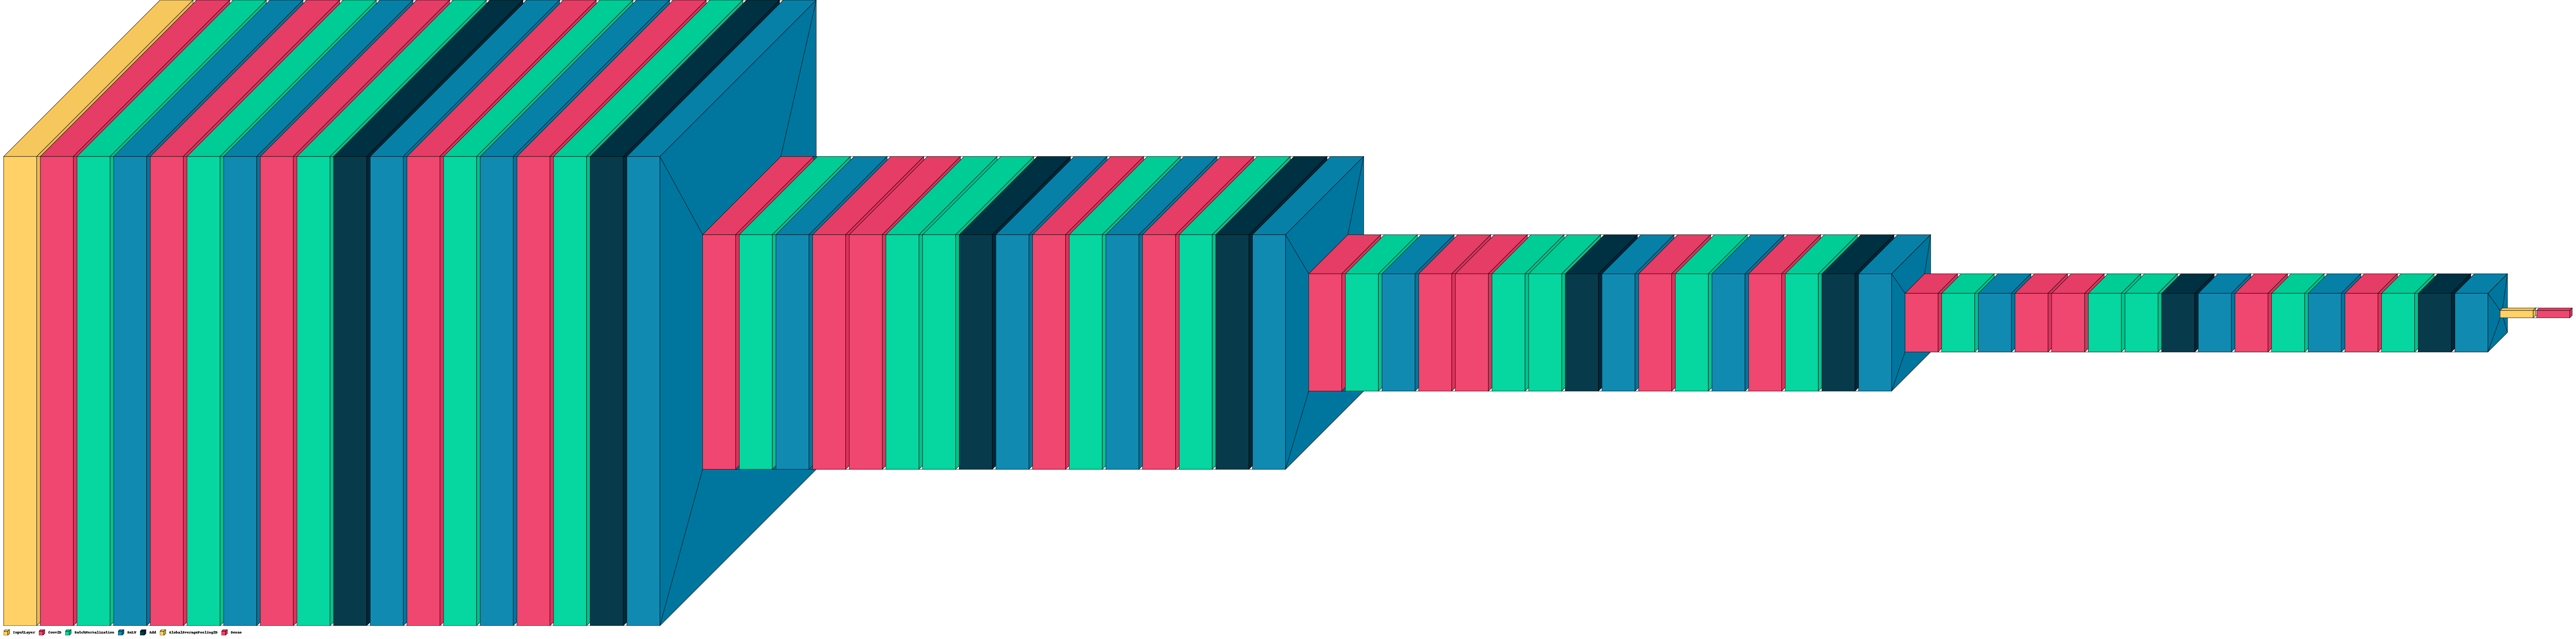

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
import visualkeras
from PIL import Image
from IPython.display import display

def resnet_block(input_tensor, filters, stride=1):
    x = Conv2D(filters, kernel_size=3, padding='same', strides=stride, use_bias=False)(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=3, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, use_bias=False)(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

def build_resnet18(input_shape=(64, 64, 3), num_classes=43):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, stride=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, stride=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, stride=2)
    x = resnet_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model

# Create the model
model_resnet18 = build_resnet18()

# Compile the model
model_resnet18.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create visualization of the model
image = visualkeras.layered_view(model_resnet18, legend=True, scale_xy=20, scale_z=80, max_z=90)

# Display the image in a notebook
display(image)


In [ ]:
# Define the basic block for ResNet-18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=43):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
# Instantiate the model and move it to the GPU
model_ResNet = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ResNet.parameters(), lr=0.001)

epochs = 30

for epoch in range(epochs):
    train_loss, train_accuracy = train(model_ResNet, device, train_loader, optimizer, criterion)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss}, Train Accuracy: {train_accuracy}%")

    test_accuracy = test(model_ResNet, device, test_loader)
    print(f"Test Accuracy: {test_accuracy}%")

Epoch 1/30, Loss: 2.5890683090086464, Train Accuracy: 24.93243243243243%
Test Accuracy: 33.39667458432304%
Epoch 2/30, Loss: 0.7711427034519845, Train Accuracy: 74.96246246246247%
Test Accuracy: 77.18923198733175%
Epoch 3/30, Loss: 0.17503776244944233, Train Accuracy: 94.62462462462463%
Test Accuracy: 77.30799683293745%
Epoch 4/30, Loss: 0.08081333132179307, Train Accuracy: 97.57882882882883%
Test Accuracy: 88.85193982581156%
Epoch 5/30, Loss: 0.0649557252832168, Train Accuracy: 97.96171171171171%
Test Accuracy: 79.7624703087886%
Epoch 6/30, Loss: 0.045233690867767774, Train Accuracy: 98.56606606606607%
Test Accuracy: 91.31433095803642%
Epoch 7/30, Loss: 0.03798047721953236, Train Accuracy: 98.80630630630631%
Test Accuracy: 89.31908155186065%
Epoch 8/30, Loss: 0.04184365534609992, Train Accuracy: 98.67117117117117%
Test Accuracy: 93.17498020585907%
Epoch 9/30, Loss: 0.02894943743152432, Train Accuracy: 99.12162162162163%
Test Accuracy: 92.97703879651623%
Epoch 10/30, Loss: 0.0280655949

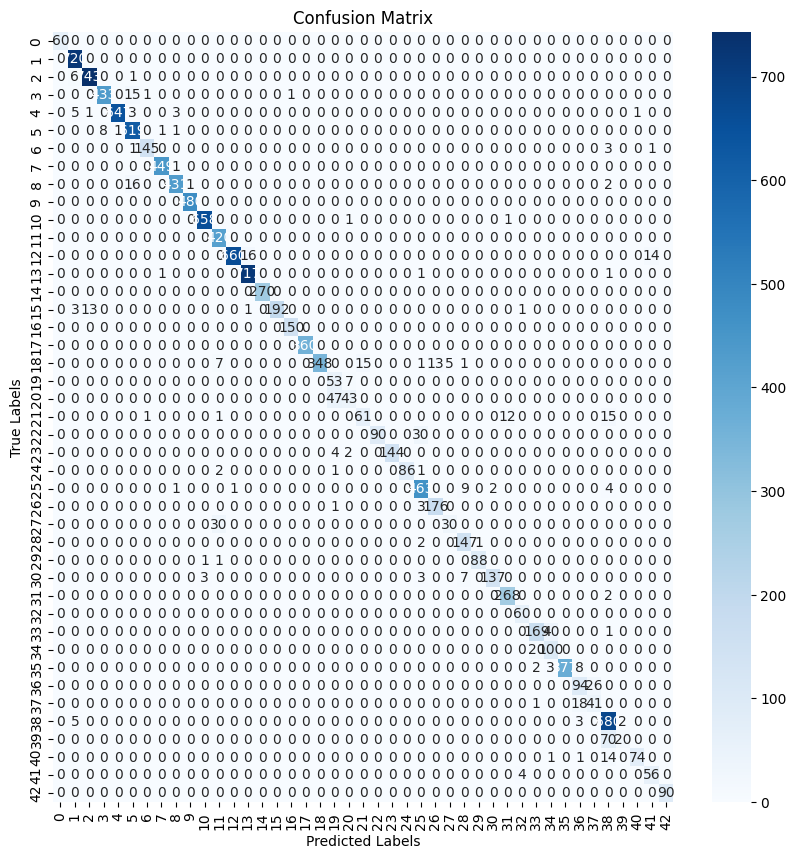

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      1.00      0.99       720
           2       0.98      0.99      0.99       750
           3       0.98      0.96      0.97       450
           4       1.00      0.98      0.99       660
           5       0.95      0.98      0.96       630
           6       0.99      0.97      0.98       150
           7       1.00      1.00      1.00       450
           8       0.99      0.96      0.97       450
           9       1.00      1.00      1.00       480
          10       0.99      1.00      1.00       660
          11       0.91      1.00      0.95       420
          12       1.00      0.96      0.98       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       1.00      0.91      0.96       210
          16       0.99      1.00      1.00       150
    

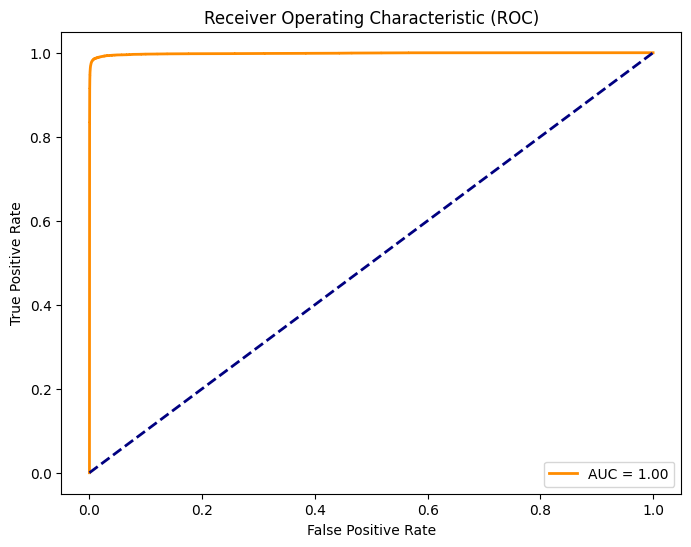

Mean Average Precision (mAP): 0.9301365690639894


In [ ]:
evaluate_model(model_ResNet, test_loader, device, num_classes=43)

In [ ]:
from torchsummary import summary

# Print model summary (for parameters count)
# Ensure the model_ResNet is defined and correctly set to the device
model_ResNet = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=43).to(device)
summary(model_ResNet, input_size=(3, 64, 64))  # Input shape as CxHxW


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

In [ ]:
torch.save(model_ResNet.state_dict(), 'resnet_model.pth')